# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

2092900


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF4_4T1Primary22bit')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
# The output codebook filename
#codebook_file = os.path.join(library_folder, 'codebook.csv') # not used in this jupyter
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
#readout_savefile = os.path.join(library_folder, 'readouts.csv') # not used in this jupyter

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


In [7]:
mRNA_fasta_file

'/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa'

## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = cdna#pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 2.4 s, sys: 433 ms, total: 2.83 s
Wall time: 3.02 s


In [10]:
print(mRNA_fasta_file)

/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa


# Load gene-selection

In [11]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/marker_gene_mean_exp.csv


## Loading ends here

# Design targeting sequences

In [12]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a','Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))
    break

In [13]:
gene_ids = target_gene_mean_exp_df.index.values

In [14]:
len(gene_ids)

394

In [15]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

In [18]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 1741 transcripts for 394 target genes.
Gene	Transcript	N_probes
Trdv4
	ENSMUST00000103679.3	415
Trbc2
	ENSMUST00000103299.3	663
Trdc
	ENSMUST00000196323.2	3836
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Gramd3
	ENSMUST00000237355.2	2600
	ENSMUST00000237422.2	2324
	ENSMUST00000235794.2	1555
	ENSMUST00000237716.2	3717
	ENSMUST00000070166.6	2576
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Prkaa1
	ENSMUST00000228218.2	4589
	ENSMUST00000051186.9	4626
Tnfrsf13c
	ENSMUST00000089161.10	1895
	ENSMUST00000109535.3	1954
	ENSMUST00000231049.2	598
	ENSMUST00000229984.2	442
Gpr88
	ENSMUST00000090473.7	3440
	ENSMUST00000197759.2	176
	ENSMUST00000199128.2	375
Ablim3
	ENSMUST00000166783.3	4158
	ENSMUST00000049378.15	4503
Septin3
	ENSMUST00000238416.3	5993
	ENSMUST00000239048.2	6414
	ENSMUST00000116423.3	2368
	ENSMUST

## Based on gff3 reference, keep only the protein-coding isoforms:

In [19]:
# For the selected gene_ids, laod gff3
from ChromAn.src.sequence_tools.reference_io import gff3_reader
gff3_ref = gff3_reader(gff3_file, save=True, save_filename=os.path.join(library_folder, 'gff3_info.pkl'),
                       auto_read=True)

- Invalid save_filename, skip loading.
parsing all gene information
gene:ENSMUSG00000102693
gene:ENSMUSG00000064842
gene:ENSMUSG00000051951
gene:ENSMUSG00000102851
gene:ENSMUSG00000103377
gene:ENSMUSG00000104017
gene:ENSMUSG00000103025
gene:ENSMUSG00000089699
gene:ENSMUSG00000103201
gene:ENSMUSG00000103147
gene:ENSMUSG00000103161
gene:ENSMUSG00000102331
gene:ENSMUSG00000102348
gene:ENSMUSG00000102592
gene:ENSMUSG00000088333
gene:ENSMUSG00000102343
gene:ENSMUSG00000025900
gene:ENSMUSG00000102948
gene:ENSMUSG00000104123
gene:ENSMUSG00000025902
gene:ENSMUSG00000104238
gene:ENSMUSG00000102269
gene:ENSMUSG00000118917
gene:ENSMUSG00000103003
gene:ENSMUSG00000104328
gene:ENSMUSG00000102735
gene:ENSMUSG00000098104
gene:ENSMUSG00000102175
gene:ENSMUSG00002075947
gene:ENSMUSG00000103265
gene:ENSMUSG00000103922
gene:ENSMUSG00000033845
gene:ENSMUSG00000102275
gene:ENSMUSG00000120403
gene:ENSMUSG00000025903
gene:ENSMUSG00000104217
gene:ENSMUSG00000033813
gene:ENSMUSG00000062588
gene:ENSMUSG00000103

gene:ENSMUSG00000047528
gene:ENSMUSG00000121483
gene:ENSMUSG00000102059
gene:ENSMUSG00000101046
gene:ENSMUSG00000026031
gene:ENSMUSG00000100236
gene:ENSMUSG00000026029
gene:ENSMUSG00000102719
gene:ENSMUSG00000099719
gene:ENSMUSG00000026028
gene:ENSMUSG00000026027
gene:ENSMUSG00000072295
gene:ENSMUSG00000047383
gene:ENSMUSG00000099752
gene:ENSMUSG00000077616
gene:ENSMUSG00000038079
gene:ENSMUSG00000097573
gene:ENSMUSG00000079550
gene:ENSMUSG00000101586
gene:ENSMUSG00000099563
gene:ENSMUSG00000026024
gene:ENSMUSG00000120458
gene:ENSMUSG00000026023
gene:ENSMUSG00000099922
gene:ENSMUSG00000104502
gene:ENSMUSG00000041075
gene:ENSMUSG00000097819
gene:ENSMUSG00000047361
gene:ENSMUSG00000099811
gene:ENSMUSG00000101409
gene:ENSMUSG00000026021
gene:ENSMUSG00002075401
gene:ENSMUSG00000103821
gene:ENSMUSG00000101400
gene:ENSMUSG00000026020
gene:ENSMUSG00000077345
gene:ENSMUSG00000077358
gene:ENSMUSG00000089512
gene:ENSMUSG00000089093
gene:ENSMUSG00000119961
gene:ENSMUSG00000067336
gene:ENSMUSG0000

gene:ENSMUSG00000086706
gene:ENSMUSG00000026417
gene:ENSMUSG00000042474
gene:ENSMUSG00000026420
gene:ENSMUSG00000026416
gene:ENSMUSG00000016524
gene:ENSMUSG00000016529
gene:ENSMUSG00000016528
gene:ENSMUSG00000088705
gene:ENSMUSG00000102856
gene:ENSMUSG00002075689
gene:ENSMUSG00000016526
gene:ENSMUSG00000026427
gene:ENSMUSG00000026430
gene:ENSMUSG00000101729
gene:ENSMUSG00000042349
gene:ENSMUSG00000102027
gene:ENSMUSG00000102055
gene:ENSMUSG00000026425
gene:ENSMUSG00000102733
gene:ENSMUSG00000104060
gene:ENSMUSG00000101778
gene:ENSMUSG00000099959
gene:ENSMUSG00002076189
gene:ENSMUSG00000055184
gene:ENSMUSG00000026432
gene:ENSMUSG00000095841
gene:ENSMUSG00000004552
gene:ENSMUSG00000052688
gene:ENSMUSG00000042268
gene:ENSMUSG00000042251
gene:ENSMUSG00000013275
gene:ENSMUSG00000026433
gene:ENSMUSG00000100026
gene:ENSMUSG00000026434
gene:ENSMUSG00000103569
gene:ENSMUSG00000103975
gene:ENSMUSG00000100037
gene:ENSMUSG00000026435
gene:ENSMUSG00000026436
gene:ENSMUSG00000059149
gene:ENSMUSG0000

gene:ENSMUSG00000112745
gene:ENSMUSG00000090212
gene:ENSMUSG00000112566
gene:ENSMUSG00000112748
gene:ENSMUSG00000112366
gene:ENSMUSG00000112189
gene:ENSMUSG00000112028
gene:ENSMUSG00000003923
gene:ENSMUSG00000019927
gene:ENSMUSG00000112813
gene:ENSMUSG00000093732
gene:ENSMUSG00000112582
gene:ENSMUSG00000037710
gene:ENSMUSG00000060733
gene:ENSMUSG00000112108
gene:ENSMUSG00000112608
gene:ENSMUSG00000112416
gene:ENSMUSG00000112126
gene:ENSMUSG00000111965
gene:ENSMUSG00000112624
gene:ENSMUSG00000112152
gene:ENSMUSG00000112714
gene:ENSMUSG00000112717
gene:ENSMUSG00000111999
gene:ENSMUSG00000077142
gene:ENSMUSG00000043859
gene:ENSMUSG00000112185
gene:ENSMUSG00000112414
gene:ENSMUSG00000053830
gene:ENSMUSG00000077642
gene:ENSMUSG00000019923
gene:ENSMUSG00000112862
gene:ENSMUSG00000112168
gene:ENSMUSG00000111994
gene:ENSMUSG00000052613
gene:ENSMUSG00000102584
gene:ENSMUSG00000085456
gene:ENSMUSG00000091825
gene:ENSMUSG00000112838
gene:ENSMUSG00000112427
gene:ENSMUSG00000085176
gene:ENSMUSG0000

gene:ENSMUSG00002076772
gene:ENSMUSG00000020548
gene:ENSMUSG00000118601
gene:ENSMUSG00000082857
gene:ENSMUSG00000020542
gene:ENSMUSG00000085162
gene:ENSMUSG00000065104
gene:ENSMUSG00000120678
gene:ENSMUSG00000033352
gene:ENSMUSG00000076460
gene:ENSMUSG00000018347
gene:ENSMUSG00000056752
gene:ENSMUSG00000084967
gene:ENSMUSG00000053930
gene:ENSMUSG00000080978
gene:ENSMUSG00000072834
gene:ENSMUSG00000048070
gene:ENSMUSG00000085683
gene:ENSMUSG00000085926
gene:ENSMUSG00000050270
gene:ENSMUSG00000020910
gene:ENSMUSG00000069844
gene:ENSMUSG00000020908
gene:ENSMUSG00000098855
gene:ENSMUSG00000087410
gene:ENSMUSG00000033196
gene:ENSMUSG00000085479
gene:ENSMUSG00000056328
gene:ENSMUSG00000085348
gene:ENSMUSG00000057003
gene:ENSMUSG00000055775
gene:ENSMUSG00000060180
gene:ENSMUSG00002076393
gene:ENSMUSG00000033066
gene:ENSMUSG00000087058
gene:ENSMUSG00000049928
gene:ENSMUSG00000020907
gene:ENSMUSG00000097886
gene:ENSMUSG00000033044
gene:ENSMUSG00000020905
gene:ENSMUSG00000055134
gene:ENSMUSG0000

gene:ENSMUSG00000084793
gene:ENSMUSG00000103704
gene:ENSMUSG00000035451
gene:ENSMUSG00000046782
gene:ENSMUSG00000085851
gene:ENSMUSG00000066489
gene:ENSMUSG00000112911
gene:ENSMUSG00000111886
gene:ENSMUSG00000112704
gene:ENSMUSG00000035431
gene:ENSMUSG00000045930
gene:ENSMUSG00000120215
gene:ENSMUSG00000112487
gene:ENSMUSG00000112785
gene:ENSMUSG00000112531
gene:ENSMUSG00000112649
gene:ENSMUSG00000097443
gene:ENSMUSG00000020986
gene:ENSMUSG00000060121
gene:ENSMUSG00000065232
gene:ENSMUSG00000020993
gene:ENSMUSG00000020994
gene:ENSMUSG00000066487
gene:ENSMUSG00000060566
gene:ENSMUSG00000021000
gene:ENSMUSG00000077505
gene:ENSMUSG00000035329
gene:ENSMUSG00002075460
gene:ENSMUSG00000112385
gene:ENSMUSG00000098229
gene:ENSMUSG00000112583
gene:ENSMUSG00000112867
gene:ENSMUSG00000112671
gene:ENSMUSG00000111978
gene:ENSMUSG00000112851
gene:ENSMUSG00000077586
gene:ENSMUSG00000077603
gene:ENSMUSG00000112355
gene:ENSMUSG00000112050
gene:ENSMUSG00000112455
gene:ENSMUSG00000112092
gene:ENSMUSG0000

gene:ENSMUSG00000114762
gene:ENSMUSG00000114717
gene:ENSMUSG00000120871
gene:ENSMUSG00000102542
gene:ENSMUSG00002076822
gene:ENSMUSG00000120208
gene:ENSMUSG00000114444
gene:ENSMUSG00000114846
gene:ENSMUSG00000114730
gene:ENSMUSG00000021624
gene:ENSMUSG00000034751
gene:ENSMUSG00000091906
gene:ENSMUSG00000090329
gene:ENSMUSG00000091577
gene:ENSMUSG00000047643
gene:ENSMUSG00002075671
gene:ENSMUSG00000095940
gene:ENSMUSG00002076400
gene:ENSMUSG00000114206
gene:ENSMUSG00000119233
gene:ENSMUSG00000032621
gene:ENSMUSG00000120696
gene:ENSMUSG00000021709
gene:ENSMUSG00000114276
gene:ENSMUSG00000114637
gene:ENSMUSG00000021710
gene:ENSMUSG00000042743
gene:ENSMUSG00000021711
gene:ENSMUSG00000118537
gene:ENSMUSG00000021712
gene:ENSMUSG00000021713
gene:ENSMUSG00000021714
gene:ENSMUSG00000046169
gene:ENSMUSG00000120566
gene:ENSMUSG00000021715
gene:ENSMUSG00000084860
gene:ENSMUSG00000021716
gene:ENSMUSG00000042655
gene:ENSMUSG00000114326
gene:ENSMUSG00000021719
gene:ENSMUSG00000021718
gene:ENSMUSG0000

gene:ENSMUSG00000022440
gene:ENSMUSG00000116307
gene:ENSMUSG00000044933
gene:ENSMUSG00000068226
gene:ENSMUSG00000033220
gene:ENSMUSG00000116097
gene:ENSMUSG00000018008
gene:ENSMUSG00000043460
gene:ENSMUSG00000116260
gene:ENSMUSG00000018169
gene:ENSMUSG00000033170
gene:ENSMUSG00000116499
gene:ENSMUSG00000049521
gene:ENSMUSG00000043501
gene:ENSMUSG00000097085
gene:ENSMUSG00000033128
gene:ENSMUSG00000099267
gene:ENSMUSG00000116069
gene:ENSMUSG00000022436
gene:ENSMUSG00000084864
gene:ENSMUSG00000116165
gene:ENSMUSG00000068220
gene:ENSMUSG00000033099
gene:ENSMUSG00000033088
gene:ENSMUSG00000116505
gene:ENSMUSG00000099180
gene:ENSMUSG00000115867
gene:ENSMUSG00000116262
gene:ENSMUSG00000120518
gene:ENSMUSG00000096210
gene:ENSMUSG00000006378
gene:ENSMUSG00000116378
gene:ENSMUSG00000114755
gene:ENSMUSG00000116287
gene:ENSMUSG00000033055
gene:ENSMUSG00000115887
gene:ENSMUSG00000033047
gene:ENSMUSG00000092974
gene:ENSMUSG00000033039
gene:ENSMUSG00000033029
gene:ENSMUSG00000033020
gene:ENSMUSG0000

gene:ENSMUSG00000116538
gene:ENSMUSG00000116808
gene:ENSMUSG00000046613
gene:ENSMUSG00000116764
gene:ENSMUSG00000080669
gene:ENSMUSG00000033809
gene:ENSMUSG00000115219
gene:ENSMUSG00000115293
gene:ENSMUSG00000051146
gene:ENSMUSG00000022842
gene:ENSMUSG00000006998
gene:ENSMUSG00000090319
gene:ENSMUSG00000045983
gene:ENSMUSG00000077239
gene:ENSMUSG00000050821
gene:ENSMUSG00000022843
gene:ENSMUSG00000021018
gene:ENSMUSG00000022847
gene:ENSMUSG00000006958
gene:ENSMUSG00000065372
gene:ENSMUSG00000116776
gene:ENSMUSG00000116922
gene:ENSMUSG00000116721
gene:ENSMUSG00000099764
gene:ENSMUSG00000116850
gene:ENSMUSG00000116659
gene:ENSMUSG00000116732
gene:ENSMUSG00000116592
gene:ENSMUSG00000116710
gene:ENSMUSG00000086936
gene:ENSMUSG00000116731
gene:ENSMUSG00000090356
gene:ENSMUSG00000005958
gene:ENSMUSG00000116843
gene:ENSMUSG00000096918
gene:ENSMUSG00000098400
gene:ENSMUSG00000116632
gene:ENSMUSG00000120420
gene:ENSMUSG00000033653
gene:ENSMUSG00000043391
gene:ENSMUSG00000022853
gene:ENSMUSG0000

gene:ENSMUSG00000093289
gene:ENSMUSG00000092887
gene:ENSMUSG00000092713
gene:ENSMUSG00000045761
gene:ENSMUSG00000089779
gene:ENSMUSG00000044375
gene:ENSMUSG00000117075
gene:ENSMUSG00000024059
gene:ENSMUSG00000055471
gene:ENSMUSG00000117126
gene:ENSMUSG00000117046
gene:ENSMUSG00002076036
gene:ENSMUSG00000117247
gene:ENSMUSG00000098193
gene:ENSMUSG00000039770
gene:ENSMUSG00000024063
gene:ENSMUSG00000118930
gene:ENSMUSG00000117096
gene:ENSMUSG00000120305
gene:ENSMUSG00000054469
gene:ENSMUSG00000081492
gene:ENSMUSG00000088224
gene:ENSMUSG00000117292
gene:ENSMUSG00000043705
gene:ENSMUSG00000117088
gene:ENSMUSG00000024064
gene:ENSMUSG00000117023
gene:ENSMUSG00000117102
gene:ENSMUSG00000117118
gene:ENSMUSG00000117228
gene:ENSMUSG00000090168
gene:ENSMUSG00000024065
gene:ENSMUSG00000117257
gene:ENSMUSG00000024066
gene:ENSMUSG00000117182
gene:ENSMUSG00000088060
gene:ENSMUSG00000038541
gene:ENSMUSG00000117038
gene:ENSMUSG00000117226
gene:ENSMUSG00000117195
gene:ENSMUSG00000117031
gene:ENSMUSG0000

gene:ENSMUSG00000037262
gene:ENSMUSG00000037254
gene:ENSMUSG00000025780
gene:ENSMUSG00000086748
gene:ENSMUSG00000061186
gene:ENSMUSG00002076942
gene:ENSMUSG00002075140
gene:ENSMUSG00000092793
gene:ENSMUSG00000077972
gene:ENSMUSG00000077038
gene:ENSMUSG00000080653
gene:ENSMUSG00000076126
gene:ENSMUSG00002075055
gene:ENSMUSG00000077834
gene:ENSMUSG00000077998
gene:ENSMUSG00000076959
gene:ENSMUSG00000080504
gene:ENSMUSG00000077981
gene:ENSMUSG00000076983
gene:ENSMUSG00000078026
gene:ENSMUSG00002075960
gene:ENSMUSG00000077049
gene:ENSMUSG00000119771
gene:ENSMUSG00000076028
gene:ENSMUSG00000119803
gene:ENSMUSG00002075143
gene:ENSMUSG00000119247
gene:ENSMUSG00000095269
gene:ENSMUSG00000119292
gene:ENSMUSG00000080459
gene:ENSMUSG00002076944
gene:ENSMUSG00000119793
gene:ENSMUSG00000119385
gene:ENSMUSG00000119608
gene:ENSMUSG00000119626
gene:ENSMUSG00002075541
gene:ENSMUSG00002076617
gene:ENSMUSG00000119508
gene:ENSMUSG00000119566
gene:ENSMUSG00000119137
gene:ENSMUSG00002076075
gene:ENSMUSG0000

gene:ENSMUSG00000082903
gene:ENSMUSG00000083047
gene:ENSMUSG00000083787
gene:ENSMUSG00000080895
gene:ENSMUSG00000086171
gene:ENSMUSG00000027419
gene:ENSMUSG00000087115
gene:ENSMUSG00000027420
gene:ENSMUSG00000082987
gene:ENSMUSG00000081293
gene:ENSMUSG00000080711
gene:ENSMUSG00000015932
gene:ENSMUSG00000027422
gene:ENSMUSG00000037307
gene:ENSMUSG00000086384
gene:ENSMUSG00000074758
gene:ENSMUSG00000082480
gene:ENSMUSG00000120315
gene:ENSMUSG00000085127
gene:ENSMUSG00000027423
gene:ENSMUSG00000082436
gene:ENSMUSG00000065725
gene:ENSMUSG00000077714
gene:ENSMUSG00000027424
gene:ENSMUSG00000037279
gene:ENSMUSG00000084837
gene:ENSMUSG00000081450
gene:ENSMUSG00000082313
gene:ENSMUSG00000027425
gene:ENSMUSG00000098387
gene:ENSMUSG00000083674
gene:ENSMUSG00000037259
gene:ENSMUSG00000027427
gene:ENSMUSG00000027428
gene:ENSMUSG00000027429
gene:ENSMUSG00000074754
gene:ENSMUSG00000027430
gene:ENSMUSG00002076136
gene:ENSMUSG00000084306
gene:ENSMUSG00000027431
gene:ENSMUSG00000082858
gene:ENSMUSG0000

gene:ENSMUSG00000027937
gene:ENSMUSG00000027938
gene:ENSMUSG00000052310
gene:ENSMUSG00000027936
gene:ENSMUSG00000042404
gene:ENSMUSG00000099199
gene:ENSMUSG00000105350
gene:ENSMUSG00000042390
gene:ENSMUSG00000108394
gene:ENSMUSG00000108689
gene:ENSMUSG00000027932
gene:ENSMUSG00000027933
gene:ENSMUSG00000027931
gene:ENSMUSG00000087411
gene:ENSMUSG00000105746
gene:ENSMUSG00000001016
gene:ENSMUSG00000001018
gene:ENSMUSG00000001017
gene:ENSMUSG00000120231
gene:ENSMUSG00000044080
gene:ENSMUSG00000042312
gene:ENSMUSG00000042306
gene:ENSMUSG00000074457
gene:ENSMUSG00000084456
gene:ENSMUSG00000094018
gene:ENSMUSG00000065079
gene:ENSMUSG00000001021
gene:ENSMUSG00000105518
gene:ENSMUSG00000001020
gene:ENSMUSG00000001023
gene:ENSMUSG00000001025
gene:ENSMUSG00000105644
gene:ENSMUSG00000063767
gene:ENSMUSG00000056054
gene:ENSMUSG00000056071
gene:ENSMUSG00000105819
gene:ENSMUSG00000106117
gene:ENSMUSG00000042250
gene:ENSMUSG00000105892
gene:ENSMUSG00000096621
gene:ENSMUSG00000106174
gene:ENSMUSG0000

gene:ENSMUSG00000040533
gene:ENSMUSG00000085804
gene:ENSMUSG00000086262
gene:ENSMUSG00000088041
gene:ENSMUSG00000078531
gene:ENSMUSG00000087171
gene:ENSMUSG00000086856
gene:ENSMUSG00000028909
gene:ENSMUSG00000028910
gene:ENSMUSG00000120687
gene:ENSMUSG00000028911
gene:ENSMUSG00000102602
gene:ENSMUSG00000085667
gene:ENSMUSG00000083013
gene:ENSMUSG00000118394
gene:ENSMUSG00000070720
gene:ENSMUSG00000028906
gene:ENSMUSG00002075479
gene:ENSMUSG00000084869
gene:ENSMUSG00000070717
gene:ENSMUSG00000083368
gene:ENSMUSG00000102796
gene:ENSMUSG00000050511
gene:ENSMUSG00000081394
gene:ENSMUSG00000040025
gene:ENSMUSG00002075354
gene:ENSMUSG00000083757
gene:ENSMUSG00000028901
gene:ENSMUSG00000084105
gene:ENSMUSG00000100813
gene:ENSMUSG00000099937
gene:ENSMUSG00000077323
gene:ENSMUSG00000120711
gene:ENSMUSG00000028899
gene:ENSMUSG00000089687
gene:ENSMUSG00000086290
gene:ENSMUSG00002075525
gene:ENSMUSG00000065097
gene:ENSMUSG00000064604
gene:ENSMUSG00000064949
gene:ENSMUSG00000080615
gene:ENSMUSG0000

gene:ENSMUSG00000099324
gene:ENSMUSG00000059352
gene:ENSMUSG00000029470
gene:ENSMUSG00000029471
gene:ENSMUSG00000105613
gene:ENSMUSG00000029472
gene:ENSMUSG00000120987
gene:ENSMUSG00000029474
gene:ENSMUSG00000029475
gene:ENSMUSG00000105979
gene:ENSMUSG00000105311
gene:ENSMUSG00000056735
gene:ENSMUSG00000106555
gene:ENSMUSG00000049686
gene:ENSMUSG00000029477
gene:ENSMUSG00000105107
gene:ENSMUSG00000080836
gene:ENSMUSG00000054434
gene:ENSMUSG00000029449
gene:ENSMUSG00000104951
gene:ENSMUSG00000090086
gene:ENSMUSG00000104156
gene:ENSMUSG00000105881
gene:ENSMUSG00000038384
gene:ENSMUSG00000029440
gene:ENSMUSG00000029445
gene:ENSMUSG00000104606
gene:ENSMUSG00000029442
gene:ENSMUSG00000094664
gene:ENSMUSG00000087063
gene:ENSMUSG00000087336
gene:ENSMUSG00000029438
gene:ENSMUSG00000065191
gene:ENSMUSG00000104830
gene:ENSMUSG00000086700
gene:ENSMUSG00000038342
gene:ENSMUSG00000106254
gene:ENSMUSG00000104940
gene:ENSMUSG00000106636
gene:ENSMUSG00000082532
gene:ENSMUSG00000029437
gene:ENSMUSG0000

gene:ENSMUSG00000101191
gene:ENSMUSG00000101162
gene:ENSMUSG00000001930
gene:ENSMUSG00000038115
gene:ENSMUSG00000089834
gene:ENSMUSG00000088959
gene:ENSMUSG00000049107
gene:ENSMUSG00000107623
gene:ENSMUSG00000101659
gene:ENSMUSG00000108163
gene:ENSMUSG00000045534
gene:ENSMUSG00000110390
gene:ENSMUSG00000102771
gene:ENSMUSG00000120976
gene:ENSMUSG00000047976
gene:ENSMUSG00000038077
gene:ENSMUSG00000097596
gene:ENSMUSG00000118420
gene:ENSMUSG00000000399
gene:ENSMUSG00000107368
gene:ENSMUSG00000030344
gene:ENSMUSG00000030345
gene:ENSMUSG00000030346
gene:ENSMUSG00000106878
gene:ENSMUSG00000030347
gene:ENSMUSG00000121058
gene:ENSMUSG00000106898
gene:ENSMUSG00000107389
gene:ENSMUSG00000000183
gene:ENSMUSG00000000182
gene:ENSMUSG00000038028
gene:ENSMUSG00000097525
gene:ENSMUSG00000107379
gene:ENSMUSG00000000184
gene:ENSMUSG00000097166
gene:ENSMUSG00000120876
gene:ENSMUSG00000107378
gene:ENSMUSG00000106755
gene:ENSMUSG00000062365
gene:ENSMUSG00000107013
gene:ENSMUSG00000081113
gene:ENSMUSG0000

gene:ENSMUSG00000030641
gene:ENSMUSG00000061119
gene:ENSMUSG00000109268
gene:ENSMUSG00000108994
gene:ENSMUSG00000121498
gene:ENSMUSG00000097644
gene:ENSMUSG00000054061
gene:ENSMUSG00000051515
gene:ENSMUSG00000088877
gene:ENSMUSG00000109196
gene:ENSMUSG00000087412
gene:ENSMUSG00000109175
gene:ENSMUSG00000109315
gene:ENSMUSG00000109195
gene:ENSMUSG00000109077
gene:ENSMUSG00000109226
gene:ENSMUSG00000109440
gene:ENSMUSG00000118493
gene:ENSMUSG00000108532
gene:ENSMUSG00000096033
gene:ENSMUSG00000108315
gene:ENSMUSG00000108516
gene:ENSMUSG00000108433
gene:ENSMUSG00002075722
gene:ENSMUSG00000119638
gene:ENSMUSG00000108786
gene:ENSMUSG00000108429
gene:ENSMUSG00000108628
gene:ENSMUSG00000048078
gene:ENSMUSG00000108528
gene:ENSMUSG00000076143
gene:ENSMUSG00000099030
gene:ENSMUSG00000085751
gene:ENSMUSG00000082780
gene:ENSMUSG00000085792
gene:ENSMUSG00000053049
gene:ENSMUSG00000085443
gene:ENSMUSG00000108635
gene:ENSMUSG00002076783
gene:ENSMUSG00000085560
gene:ENSMUSG00000087980
gene:ENSMUSG0000

gene:ENSMUSG00000110274
gene:ENSMUSG00000101613
gene:ENSMUSG00000065636
gene:ENSMUSG00000110380
gene:ENSMUSG00000110198
gene:ENSMUSG00000110134
gene:ENSMUSG00000031736
gene:ENSMUSG00000095651
gene:ENSMUSG00000031737
gene:ENSMUSG00000110290
gene:ENSMUSG00000031738
gene:ENSMUSG00000110023
gene:ENSMUSG00000078967
gene:ENSMUSG00000031740
gene:ENSMUSG00000109669
gene:ENSMUSG00000033192
gene:ENSMUSG00000078144
gene:ENSMUSG00002076561
gene:ENSMUSG00000055368
gene:ENSMUSG00000109651
gene:ENSMUSG00000071047
gene:ENSMUSG00000078964
gene:ENSMUSG00000057400
gene:ENSMUSG00000110714
gene:ENSMUSG00000056973
gene:ENSMUSG00000110496
gene:ENSMUSG00000061959
gene:ENSMUSG00000110659
gene:ENSMUSG00000031725
gene:ENSMUSG00000057074
gene:ENSMUSG00000074156
gene:ENSMUSG00000110718
gene:ENSMUSG00000110687
gene:ENSMUSG00000110670
gene:ENSMUSG00000110695
gene:ENSMUSG00000118579
gene:ENSMUSG00000058019
gene:ENSMUSG00000110534
gene:ENSMUSG00000110559
gene:ENSMUSG00000110713
gene:ENSMUSG00000110672
gene:ENSMUSG0000

gene:ENSMUSG00000105187
gene:ENSMUSG00000064877
gene:ENSMUSG00000032482
gene:ENSMUSG00000104988
gene:ENSMUSG00000098973
gene:ENSMUSG00000105484
gene:ENSMUSG00000054836
gene:ENSMUSG00000106123
gene:ENSMUSG00000032485
gene:ENSMUSG00000091102
gene:ENSMUSG00000036057
gene:ENSMUSG00000032484
gene:ENSMUSG00000054792
gene:ENSMUSG00000032489
gene:ENSMUSG00000044791
gene:ENSMUSG00000104983
gene:ENSMUSG00000032491
gene:ENSMUSG00000056724
gene:ENSMUSG00000099275
gene:ENSMUSG00000105127
gene:ENSMUSG00000019659
gene:ENSMUSG00000104945
gene:ENSMUSG00000032492
gene:ENSMUSG00000059741
gene:ENSMUSG00000044664
gene:ENSMUSG00000032493
gene:ENSMUSG00000058398
gene:ENSMUSG00000047257
gene:ENSMUSG00000049719
gene:ENSMUSG00000048752
gene:ENSMUSG00000049555
gene:ENSMUSG00000044037
gene:ENSMUSG00000105140
gene:ENSMUSG00000096393
gene:ENSMUSG00002074938
gene:ENSMUSG00000032494
gene:ENSMUSG00000032495
gene:ENSMUSG00000106234
gene:ENSMUSG00000066319
gene:ENSMUSG00000102060
gene:ENSMUSG00000057802
gene:ENSMUSG0000

gene:ENSMUSG00000101201
gene:ENSMUSG00000100438
gene:ENSMUSG00000101286
gene:ENSMUSG00000100268
gene:ENSMUSG00000101343
gene:ENSMUSG00000101907
gene:ENSMUSG00000100035
gene:ENSMUSG00000101072
gene:ENSMUSG00000100994
gene:ENSMUSG00000100861
gene:ENSMUSG00000100317
gene:ENSMUSG00000101329
gene:ENSMUSG00000100532
gene:ENSMUSG00000099374
gene:ENSMUSG00000100882
gene:ENSMUSG00000101772
gene:ENSMUSG00000099667
gene:ENSMUSG00000099925
gene:ENSMUSG00000101582
gene:ENSMUSG00000101273
gene:ENSMUSG00000101508
gene:ENSMUSG00000100339
gene:ENSMUSG00000099546
gene:ENSMUSG00000101884
gene:ENSMUSG00000100906
gene:ENSMUSG00000100092
gene:ENSMUSG00000100284
gene:ENSMUSG00002075613
gene:ENSMUSG00000100986
gene:ENSMUSG00000101718
gene:ENSMUSG00002076259
gene:ENSMUSG00000099736
gene:ENSMUSG00000101657
gene:ENSMUSG00000100740
gene:ENSMUSG00000100718
gene:ENSMUSG00000100407
gene:ENSMUSG00000095153
gene:ENSMUSG00000100946
gene:ENSMUSG00000101851
gene:ENSMUSG00000100531
gene:ENSMUSG00000099483
gene:ENSMUSG0000

In [20]:
# Test gene-search:
gene_info = gff3_ref._search_gene_by_name('Cd3g')
if len(gene_info) == 1:
    print(gene_info[0]['infos'])
    # load isoforms:
    for _transcript in gene_info[0]['Children']:
        print(_transcript['infos'])
    #print(gene_info[0].keys())

{'ID': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g', 'biotype': 'protein_coding', 'description': 'CD3 antigen%2C gamma polypeptide [Source:MGI Symbol%3BAcc:MGI:88333]', 'gene_id': 'ENSMUSG00000002033', 'logic_name': 'ensembl_havana_gene_mus_musculus', 'version': '15'}
{'ID': 'transcript:ENSMUST00000002101', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23123.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000002101', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000159019', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000159019', 'transcript_support_level': '2 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000160886', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000160886', 'transcript_s

In [21]:
for _gene, _ts_2_probes in probe_dict.items():
    # search this gene:
    gene_info = gff3_ref._search_gene_by_name(_gene)[0]
    # only keep protein-coding isoform if this is a protein-coding gene:
    if gene_info['infos']['biotype'] == 'protein_coding':
        # load isoforms:
        for _transcript in gene_info['Children']:
            print(_transcript['infos'])
            if _transcript['infos']['biotype'] != 'protein_coding':
                # delete isoform:
                print(f"delete {_gene}, {_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}, biotype:{_transcript['infos']['biotype']}")
                del(probe_dict[_gene][f"{_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}"])

{'ID': 'transcript:ENSMUST00000237355', 'Parent': 'gene:ENSMUSG00000001700', 'Name': 'Gramd3-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50290.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000237355', 'version': '2'}
{'ID': 'transcript:ENSMUST00000237422', 'Parent': 'gene:ENSMUSG00000001700', 'Name': 'Gramd3-204', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000237422', 'version': '2'}
{'ID': 'transcript:ENSMUST00000235794', 'Parent': 'gene:ENSMUSG00000001700', 'Name': 'Gramd3-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000235794', 'version': '2'}
delete Gramd3, ENSMUST00000235794.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000070166', 'Parent': 'gene:ENSMUSG00000001700', 'Name': 'Gramd3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50290.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000070166', 'transcript_support_level': '1 (assigned to previous version 5)', 'version':

{'ID': 'transcript:ENSMUST00000022722', 'Parent': 'gene:ENSMUSG00000022126', 'Name': 'Acod1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS49558.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000022722', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000159552', 'Parent': 'gene:ENSMUSG00000022150', 'Name': 'Dab2-207', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000159552', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Dab2, ENSMUST00000159552.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000078019', 'Parent': 'gene:ENSMUSG00000022150', 'Name': 'Dab2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37030.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000078019', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000159046', 'Parent': 'gene:ENSMUSG000

{'ID': 'transcript:ENSMUST00000105307', 'Parent': 'gene:ENSMUSG00000020042', 'Name': 'Btbd11-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24091.2', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000105307', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000020231', 'Parent': 'gene:ENSMUSG00000020042', 'Name': 'Btbd11-201', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000020231', 'transcript_support_level': '5 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000105306', 'Parent': 'gene:ENSMUSG00000020042', 'Name': 'Btbd11-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36018.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000105306', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000135235', 'Parent': 'gene:ENSMUSG00000020042', 'Name': 'Btbd11-205', 'biotype': 'protein_coding_CDS_not_defined', 'transcr

{'ID': 'transcript:ENSMUST00000058579', 'Parent': 'gene:ENSMUSG00000045538', 'Name': 'Ddx28-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22626.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000058579', 'transcript_support_level': 'NA (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000216853', 'Parent': 'gene:ENSMUSG00000075266', 'Name': 'Cenpw-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000216853', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000099985', 'Parent': 'gene:ENSMUSG00000075266', 'Name': 'Cenpw-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS35876.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000099985', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000170089', 'Parent': 'gene:ENSMUSG00000015053', 'Name': 'Gata2-202', 'biotype': 'protein_cod

{'ID': 'transcript:ENSMUST00000067492', 'Parent': 'gene:ENSMUSG00000054422', 'Name': 'Fabp1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20226.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000067492', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000023336', 'Parent': 'gene:ENSMUSG00000022657', 'Name': 'Cd96-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37348.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000023336', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000123566', 'Parent': 'gene:ENSMUSG00000028991', 'Name': 'Mtor-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000123566', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Mtor, ENSMUST00000123566.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000103221', 'Parent': 'gene:ENSMUSG00000028991', 'N

{'ID': 'transcript:ENSMUST00000205997', 'Parent': 'gene:ENSMUSG00000030724', 'Name': 'Cd19-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000205997', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
delete Cd19, ENSMUST00000205997.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000032968', 'Parent': 'gene:ENSMUSG00000030724', 'Name': 'Cd19-201', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000032968', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000206325', 'Parent': 'gene:ENSMUSG00000030724', 'Name': 'Cd19-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21828.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000206325', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000205848', 'Parent': 'gene:ENSMUSG00000030724', 'Name': 'Cd19-202', 'biotype': 'retained_intron

{'ID': 'transcript:ENSMUST00000027131', 'Parent': 'gene:ENSMUSG00000025986', 'Name': 'Slc39a10-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS14936.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027131', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000141226', 'Parent': 'gene:ENSMUSG00000025986', 'Name': 'Slc39a10-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000141226', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
delete Slc39a10, ENSMUST00000141226.3, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000186852', 'Parent': 'gene:ENSMUSG00000025986', 'Name': 'Slc39a10-204', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000186852', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000185520', 'Parent': 'gene:ENSMUSG00000025986', 'Name': 'Slc39a10-203', 'biotype': 'protein_cod

{'ID': 'transcript:ENSMUST00000236579', 'Parent': 'gene:ENSMUSG00000024803', 'Name': 'Ankrd1-204', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000236579', 'version': '2'}
delete Ankrd1, ENSMUST00000236579.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000235941', 'Parent': 'gene:ENSMUSG00000024803', 'Name': 'Ankrd1-203', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000235941', 'version': '2'}
delete Ankrd1, ENSMUST00000235941.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000237142', 'Parent': 'gene:ENSMUSG00000024803', 'Name': 'Ankrd1-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29771.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000237142', 'version': '2'}
{'ID': 'transcript:ENSMUST00000025718', 'Parent': 'gene:ENSMUSG00000024803', 'Name': 'Ankrd1-201', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000025718', 'transcript_support_level': '1 (assigned to previous 

{'ID': 'transcript:ENSMUST00000232423', 'Parent': 'gene:ENSMUSG00000003527', 'Name': 'Ess2-205', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000232423', 'version': '2'}
{'ID': 'transcript:ENSMUST00000003621', 'Parent': 'gene:ENSMUSG00000003527', 'Name': 'Ess2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS28013.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000003621', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000232366', 'Parent': 'gene:ENSMUSG00000003527', 'Name': 'Ess2-204', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000232366', 'version': '2'}
delete Ess2, ENSMUST00000232366.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000232111', 'Parent': 'gene:ENSMUSG00000003527', 'Name': 'Ess2-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000232111', 'version': '2'}
delete Ess2, ENSMUST00000232111.2, biotype:retained_intron
{'ID': 'transc

{'ID': 'transcript:ENSMUST00000024044', 'Parent': 'gene:ENSMUSG00000023274', 'Name': 'Cd4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20535.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000024044', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000145977', 'Parent': 'gene:ENSMUSG00000023274', 'Name': 'Cd4-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000145977', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Cd4, ENSMUST00000145977.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000145818', 'Parent': 'gene:ENSMUSG00000023274', 'Name': 'Cd4-203', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000145818', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Cd4, ENSMUST00000145818.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUS

{'ID': 'transcript:ENSMUST00000022075', 'Parent': 'gene:ENSMUSG00000021587', 'Name': 'Pcsk1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS26649.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000022075', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000135349', 'Parent': 'gene:ENSMUSG00000021587', 'Name': 'Pcsk1-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000135349', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Pcsk1, ENSMUST00000135349.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000222727', 'Parent': 'gene:ENSMUSG00000021587', 'Name': 'Pcsk1-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000222727', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000145062', 'Parent': 'gene:ENSMUSG00000029630', 'Name': 'Cyp3a25-203', 'biotype': 'nonsense_mediated_decay'

{'ID': 'transcript:ENSMUST00000030047', 'Parent': 'gene:ENSMUSG00000028362', 'Name': 'Tnfsf8-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18264.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000030047', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000039174', 'Parent': 'gene:ENSMUSG00000038151', 'Name': 'Prdm1-201', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000039174', 'transcript_support_level': '2 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000105490', 'Parent': 'gene:ENSMUSG00000038151', 'Name': 'Prdm1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23825.2', 'tag': 'basic', 'transcript_id': 'ENSMUST00000105490', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000218369', 'Parent': 'gene:ENSMUSG00000038151', 'Name': 'Prdm1-204', 'biotype': 'protein_c

{'ID': 'transcript:ENSMUST00000137265', 'Parent': 'gene:ENSMUSG00000045545', 'Name': 'Krt14-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000137265', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Krt14, ENSMUST00000137265.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000007272', 'Parent': 'gene:ENSMUSG00000045545', 'Name': 'Krt14-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25413.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000007272', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000002368', 'Parent': 'gene:ENSMUSG00000002297', 'Name': 'Dbf4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS57324.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000002368', 'transcript_support_level': '1 (assigned to previous version 15)', 'version': '16'}
{'ID': 'transcript:ENSMUST00000171808', 'Parent': 'gene:ENSMUSG0

{'ID': 'transcript:ENSMUST00000080514', 'Parent': 'gene:ENSMUSG00000062309', 'Name': 'Rpp25-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23222.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000080514', 'transcript_support_level': 'NA (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000141187', 'Parent': 'gene:ENSMUSG00000055022', 'Name': 'Cntn1-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000141187', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Cntn1, ENSMUST00000141187.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000169825', 'Parent': 'gene:ENSMUSG00000055022', 'Name': 'Cntn1-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS27763.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000169825', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000000109', 'Parent': 'gene:ENSMUSG00000055022',

{'ID': 'transcript:ENSMUST00000037453', 'Parent': 'gene:ENSMUSG00000056399', 'Name': 'Prss34-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS28514.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000037453', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000185091', 'Parent': 'gene:ENSMUSG00000051969', 'Name': 'Tlr11-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS27012.2', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000185091', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000063570', 'Parent': 'gene:ENSMUSG00000051969', 'Name': 'Tlr11-201', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000063570', 'transcript_support_level': 'NA (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000033473', 'Parent': 'gene:ENSMUSG00000031137', 'Name': 'Fgf13-201', 'biotype': 'protein_co

{'ID': 'transcript:ENSMUST00000101078', 'Parent': 'gene:ENSMUSG00000079012', 'Name': 'Serpina3m-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36538.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000101078', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000168797', 'Parent': 'gene:ENSMUSG00000079012', 'Name': 'Serpina3m-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36538.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000168797', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000153546', 'Parent': 'gene:ENSMUSG00000024675', 'Name': 'Ms4a4c-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000153546', 'transcript_support_level': '3 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000072729', 'Parent': 'gene:ENSMUSG00000024675', 'Name': 'Ms4a4c-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29

{'ID': 'transcript:ENSMUST00000233535', 'Parent': 'gene:ENSMUSG00000023828', 'Name': 'Slc22a3-202', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000233535', 'version': '2'}
delete Slc22a3, ENSMUST00000233535.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000024595', 'Parent': 'gene:ENSMUSG00000023828', 'Name': 'Slc22a3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS28391.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000024595', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000134015', 'Parent': 'gene:ENSMUSG00000055491', 'Name': 'Pprc1-207', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000134015', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Pprc1, ENSMUST00000134015.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000111899', 'Parent': 'gene:ENSMUSG00000055491', 'Name': 'Ppr

{'ID': 'transcript:ENSMUST00000066060', 'Parent': 'gene:ENSMUSG00000048251', 'Name': 'Bcl11b-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36553.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000066060', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000109887', 'Parent': 'gene:ENSMUSG00000048251', 'Name': 'Bcl11b-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS70419.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000109887', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000109891', 'Parent': 'gene:ENSMUSG00000048251', 'Name': 'Bcl11b-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36552.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000109891', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000109546', 'Parent': 'gene:ENSMUSG00000021614', 'Name': 'Vcan-203', 'biotype': 'p

{'ID': 'transcript:ENSMUST00000033326', 'Parent': 'gene:ENSMUSG00000031016', 'Name': 'Wee1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21743.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000033326', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000022592', 'Parent': 'gene:ENSMUSG00000022015', 'Name': 'Tnfsf11-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS27294.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000022592', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000072141', 'Parent': 'gene:ENSMUSG00000025047', 'Name': 'Pdcd11-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29888.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000072141', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000235871', 'Parent': 'gene:ENSMUSG00000025047',

{'ID': 'transcript:ENSMUST00000145984', 'Parent': 'gene:ENSMUSG00000052736', 'Name': 'Klrc2-205', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000145984', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000112057', 'Parent': 'gene:ENSMUSG00000052736', 'Name': 'Klrc2-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS51925.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000112057', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000071920', 'Parent': 'gene:ENSMUSG00000052736', 'Name': 'Klrc2-201', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000071920', 'transcript_support_level': '5 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000118401', 'Parent': 'gene:ENSMUSG00000052736', 'Name': 'Klrc2-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS51924.1', 'tag': 'bas

{'ID': 'transcript:ENSMUST00000023799', 'Parent': 'gene:ENSMUSG00000061397', 'Name': 'Krt79-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS27867.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000023799', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000230273', 'Parent': 'gene:ENSMUSG00000061397', 'Name': 'Krt79-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000230273', 'version': '2'}
delete Krt79, ENSMUST00000230273.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000229195', 'Parent': 'gene:ENSMUSG00000061397', 'Name': 'Krt79-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000229195', 'version': '2'}
delete Krt79, ENSMUST00000229195.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000230441', 'Parent': 'gene:ENSMUSG00000061397', 'Name': 'Krt79-204', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000230441', 'version':

{'ID': 'transcript:ENSMUST00000049430', 'Parent': 'gene:ENSMUSG00000038296', 'Name': 'Galnt18-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21751.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000049430', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000106663', 'Parent': 'gene:ENSMUSG00000038296', 'Name': 'Galnt18-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000106663', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000028045', 'Parent': 'gene:ENSMUSG00000026712', 'Name': 'Mrc1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15700.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000028045', 'transcript_support_level': '1 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000146168', 'Parent': 'gene:ENSMUSG00000026712', 'Name': 'Mrc1-202', 'biotype': 'retained

{'ID': 'transcript:ENSMUST00000068545', 'Parent': 'gene:ENSMUSG00000055137', 'Name': 'Sugct-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS26252.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000068545', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000221598', 'Parent': 'gene:ENSMUSG00000055137', 'Name': 'Sugct-205', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000221598', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000220514', 'Parent': 'gene:ENSMUSG00000055137', 'Name': 'Sugct-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000220514', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000221138', 'Parent': 'gene:ENSMUSG00000055137', 'Name': 'Sugct-203', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000221138',

{'ID': 'transcript:ENSMUST00000239207', 'Parent': 'gene:ENSMUSG00000021314', 'Name': 'Amph-206', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000239207', 'version': '2'}
{'ID': 'transcript:ENSMUST00000003345', 'Parent': 'gene:ENSMUSG00000021314', 'Name': 'Amph-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS26258.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000003345', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000200466', 'Parent': 'gene:ENSMUSG00000021314', 'Name': 'Amph-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS79165.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000200466', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000200273', 'Parent': 'gene:ENSMUSG00000021314', 'Name': 'Amph-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000200273', 'transcript_support_level': '1 (assigned t

{'ID': 'transcript:ENSMUST00000183112', 'Parent': 'gene:ENSMUSG00000034206', 'Name': 'Polq-207', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000183112', 'transcript_support_level': '2 (assigned to previous version 7)', 'version': '8'}
delete Polq, ENSMUST00000183112.8, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000071452', 'Parent': 'gene:ENSMUSG00000034206', 'Name': 'Polq-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS49845.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000071452', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000182946', 'Parent': 'gene:ENSMUSG00000034206', 'Name': 'Polq-206', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000182946', 'transcript_support_level': '2 (assigned to previous version 7)', 'version': '8'}
delete Polq, ENSMUST00000182946.8, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000054034', 'Parent': 'gene:ENSMUSG0

{'ID': 'transcript:ENSMUST00000112022', 'Parent': 'gene:ENSMUSG00000038357', 'Name': 'Camp-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS52934.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000112022', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000126214', 'Parent': 'gene:ENSMUSG00000039578', 'Name': 'Ccser1-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS51800.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000126214', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000133478', 'Parent': 'gene:ENSMUSG00000039578', 'Name': 'Ccser1-205', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000133478', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Ccser1, ENSMUST00000133478.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000131989', 'Parent': 'gene:ENSMUSG00000039578'

{'ID': 'transcript:ENSMUST00000037491', 'Parent': 'gene:ENSMUSG00000039109', 'Name': 'F13a1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS26456.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000037491', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000164727', 'Parent': 'gene:ENSMUSG00000039109', 'Name': 'F13a1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS26456.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000164727', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000224783', 'Parent': 'gene:ENSMUSG00000039109', 'Name': 'F13a1-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000224783', 'version': '3'}
delete F13a1, ENSMUST00000224783.3, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000225168', 'Parent': 'gene:ENSMUSG00000039109', 'Name': 'F13a1-205', 'biotype': 'retained_intron', 't

{'ID': 'transcript:ENSMUST00000045450', 'Parent': 'gene:ENSMUSG00000037461', 'Name': 'Ints7-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS35825.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000045450', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000193961', 'Parent': 'gene:ENSMUSG00000037461', 'Name': 'Ints7-204', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000193961', 'transcript_support_level': '2 (assigned to previous version 5)', 'version': '6'}
delete Ints7, ENSMUST00000193961.6, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000194877', 'Parent': 'gene:ENSMUSG00000037461', 'Name': 'Ints7-206', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000194877', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
delete Ints7, ENSMUST00000194877.6, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000193569', 'Parent': 'gene:ENS

{'ID': 'transcript:ENSMUST00000026126', 'Parent': 'gene:ENSMUSG00000025133', 'Name': 'Ints4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21460.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000026126', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000206644', 'Parent': 'gene:ENSMUSG00000025133', 'Name': 'Ints4-206', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000206644', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Ints4, ENSMUST00000206644.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000205481', 'Parent': 'gene:ENSMUSG00000025133', 'Name': 'Ints4-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000205481', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Ints4, ENSMUST00000205481.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000205876', 'Parent': 'gene:ENSMUSG00000025133

{'ID': 'transcript:ENSMUST00000078286', 'Parent': 'gene:ENSMUSG00000063888', 'Name': 'Rpl7l1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS28842.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000078286', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000233192', 'Parent': 'gene:ENSMUSG00000063888', 'Name': 'Rpl7l1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS28842.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000233192', 'version': '2'}
{'ID': 'transcript:ENSMUST00000233349', 'Parent': 'gene:ENSMUSG00000063888', 'Name': 'Rpl7l1-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000233349', 'version': '2'}
{'ID': 'transcript:ENSMUST00000233919', 'Parent': 'gene:ENSMUSG00000063888', 'Name': 'Rpl7l1-204', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000233919', 'version': '2'}
delete Rpl7l1, ENSMUST00000233919.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000108300', 

{'ID': 'transcript:ENSMUST00000113314', 'Parent': 'gene:ENSMUSG00000029273', 'Name': 'Sult1d1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39130.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000113314', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000166996', 'Parent': 'gene:ENSMUSG00000029273', 'Name': 'Sult1d1-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000166996', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Sult1d1, ENSMUST00000166996.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000107433', 'Parent': 'gene:ENSMUSG00000028042', 'Name': 'Zbtb7b-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17504.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000107433', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000107435', 'Parent': 'gene:EN

{'ID': 'transcript:ENSMUST00000124816', 'Parent': 'gene:ENSMUSG00000026011', 'Name': 'Ctla4-203', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000124816', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Ctla4, ENSMUST00000124816.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000027164', 'Parent': 'gene:ENSMUSG00000026011', 'Name': 'Ctla4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS14993.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027164', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000097720', 'Parent': 'gene:ENSMUSG00000026011', 'Name': 'Ctla4-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS69893.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000097720', 'transcript_support_level': '5 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000035061', 'Parent': 'gene:ENSMUSG00

{'ID': 'transcript:ENSMUST00000119080', 'Parent': 'gene:ENSMUSG00000047797', 'Name': 'Gjb1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS30314.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000119080', 'transcript_support_level': '3 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000052130', 'Parent': 'gene:ENSMUSG00000047797', 'Name': 'Gjb1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS30314.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000052130', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000119190', 'Parent': 'gene:ENSMUSG00000047797', 'Name': 'Gjb1-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS30314.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000119190', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000021306', 'Parent': 'gene:ENSMUSG00000020929', 'Name': 'Eftud2-201', 'biotype': 'prote

{'ID': 'transcript:ENSMUST00000035842', 'Parent': 'gene:ENSMUSG00000042129', 'Name': 'Rassf4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20460.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000035842', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000203029', 'Parent': 'gene:ENSMUSG00000042129', 'Name': 'Rassf4-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000203029', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000203477', 'Parent': 'gene:ENSMUSG00000042129', 'Name': 'Rassf4-203', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000203477', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Rassf4, ENSMUST00000203477.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000204313', 'Parent': 'gene:ENSMUSG00000042129', 'Name': '

{'ID': 'transcript:ENSMUST00000173492', 'Parent': 'gene:ENSMUSG00000079553', 'Name': 'Kifc1-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS57065.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000173492', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000173982', 'Parent': 'gene:ENSMUSG00000079553', 'Name': 'Kifc1-206', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000173982', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000114361', 'Parent': 'gene:ENSMUSG00000079553', 'Name': 'Kifc1-201', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000114361', 'transcript_support_level': '5 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000174507', 'Parent': 'gene:ENSMUSG00000079553', 'Name': 'Kifc1-207', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000174507', 'transcript_su

{'ID': 'transcript:ENSMUST00000153004', 'Parent': 'gene:ENSMUSG00000029833', 'Name': 'Trim24-208', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000153004', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Trim24, ENSMUST00000153004.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000149828', 'Parent': 'gene:ENSMUSG00000029833', 'Name': 'Trim24-207', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000149828', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Trim24, ENSMUST00000149828.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000031859', 'Parent': 'gene:ENSMUSG00000029833', 'Name': 'Trim24-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20008.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000031859', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000120428', 'Parent': 'gene:ENSMUSG00000

{'ID': 'transcript:ENSMUST00000012847', 'Parent': 'gene:ENSMUSG00000031494', 'Name': 'Cd209a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22073.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000012847', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000208960', 'Parent': 'gene:ENSMUSG00000031494', 'Name': 'Cd209a-204', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000208960', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000207979', 'Parent': 'gene:ENSMUSG00000031494', 'Name': 'Cd209a-203', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000207979', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000207906', 'Parent': 'gene:ENSMUSG00000031494', 'Name': 'Cd209a-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000207

{'ID': 'transcript:ENSMUST00000054414', 'Parent': 'gene:ENSMUSG00000047898', 'Name': 'Ccr4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23594.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000054414', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000215425', 'Parent': 'gene:ENSMUSG00000047898', 'Name': 'Ccr4-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23594.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000215425', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000215959', 'Parent': 'gene:ENSMUSG00000047898', 'Name': 'Ccr4-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000215959', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000006760', 'Parent': 'gene:ENSMUSG00000006585', 'Name': 'Cdt1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22741.1', 'tag': '

{'ID': 'transcript:ENSMUST00000117171', 'Parent': 'gene:ENSMUSG00000030170', 'Name': 'Wnt5b-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20474.2', 'tag': 'basic', 'transcript_id': 'ENSMUST00000117171', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000178696', 'Parent': 'gene:ENSMUSG00000030170', 'Name': 'Wnt5b-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20474.2', 'tag': 'basic', 'transcript_id': 'ENSMUST00000178696', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000118120', 'Parent': 'gene:ENSMUSG00000030170', 'Name': 'Wnt5b-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000118120', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000119369', 'Parent': 'gene:ENSMUSG00000030170', 'Name': 'Wnt5b-203', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical

{'ID': 'transcript:ENSMUST00000027146', 'Parent': 'gene:ENSMUSG00000025997', 'Name': 'Ikzf2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15026.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000027146', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000190771', 'Parent': 'gene:ENSMUSG00000025997', 'Name': 'Ikzf2-207', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000190771', 'transcript_support_level': '5 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000187184', 'Parent': 'gene:ENSMUSG00000025997', 'Name': 'Ikzf2-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000187184', 'transcript_support_level': '5 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000190855', 'Parent': 'gene:ENSMUSG00000025997', 'Name': 'Ikzf2-208', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSM

{'ID': 'transcript:ENSMUST00000044616', 'Parent': 'gene:ENSMUSG00000040738', 'Name': 'Ints8-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17967.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000044616', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000136545', 'Parent': 'gene:ENSMUSG00000040738', 'Name': 'Ints8-205', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000136545', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Ints8, ENSMUST00000136545.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000137054', 'Parent': 'gene:ENSMUSG00000040738', 'Name': 'Ints8-206', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000137054', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Ints8, ENSMUST00000137054.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transc

{'ID': 'transcript:ENSMUST00000043400', 'Parent': 'gene:ENSMUSG00000033508', 'Name': 'Asprv1-201', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000043400', 'transcript_support_level': 'NA (assigned to previous version 7)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000148158', 'Parent': 'gene:ENSMUSG00000035498', 'Name': 'Cdcp1-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000148158', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
delete Cdcp1, ENSMUST00000148158.3, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000039229', 'Parent': 'gene:ENSMUSG00000035498', 'Name': 'Cdcp1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23657.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000039229', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000140915', 'Parent': 'gene:ENSMUSG00000035498', 'Name': 'Cdcp1-202', 'b

{'ID': 'transcript:ENSMUST00000150167', 'Parent': 'gene:ENSMUSG00000049723', 'Name': 'Mmp12-207', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000150167', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000120655', 'Parent': 'gene:ENSMUSG00000049723', 'Name': 'Mmp12-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS85639.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000120655', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000005950', 'Parent': 'gene:ENSMUSG00000049723', 'Name': 'Mmp12-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22804.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000005950', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000065079', 'Parent': 'gene:ENSMUSG00000049723', 'Name': 'Mmp12-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript

{'ID': 'transcript:ENSMUST00000058352', 'Parent': 'gene:ENSMUSG00000046080', 'Name': 'Clec9a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS57454.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000058352', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000088075', 'Parent': 'gene:ENSMUSG00000046080', 'Name': 'Clec9a-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39658.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000088075', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000164513', 'Parent': 'gene:ENSMUSG00000046080', 'Name': 'Clec9a-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS57455.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000164513', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000204860', 'Parent': 'gene:ENSMUSG00000046080', 'Name': 'Clec9a-204', 'biotype': 

{'ID': 'transcript:ENSMUST00000136804', 'Parent': 'gene:ENSMUSG00000030335', 'Name': 'Mrpl51-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000136804', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Mrpl51, ENSMUST00000136804.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000032485', 'Parent': 'gene:ENSMUSG00000030335', 'Name': 'Mrpl51-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20545.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000032485', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000144380', 'Parent': 'gene:ENSMUSG00000030335', 'Name': 'Mrpl51-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000144380', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
delete Mrpl51, ENSMUST00000144380.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000049706', 

{'ID': 'transcript:ENSMUST00000004936', 'Parent': 'gene:ENSMUSG00000004814', 'Name': 'Ccl24-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS19742.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000004936', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000201401', 'Parent': 'gene:ENSMUSG00000004814', 'Name': 'Ccl24-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS19742.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000201401', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000167369', 'Parent': 'gene:ENSMUSG00000057092', 'Name': 'Fxyd3-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21125.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000167369', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000169313', 'Parent': 'gene:ENSMUSG00000057092', 'Name': 'Fxyd3-206'

{'ID': 'transcript:ENSMUST00000071057', 'Parent': 'gene:ENSMUSG00000029389', 'Name': 'Ddx55-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39281.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000071057', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000131631', 'Parent': 'gene:ENSMUSG00000029389', 'Name': 'Ddx55-203', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000131631', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Ddx55, ENSMUST00000131631.8, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000136067', 'Parent': 'gene:ENSMUSG00000029389', 'Name': 'Ddx55-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000136067', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
delete Ddx55, ENSMUST00000136067.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST0

{'ID': 'transcript:ENSMUST00000103154', 'Parent': 'gene:ENSMUSG00000057058', 'Name': 'Skap1-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25301.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000103154', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000100521', 'Parent': 'gene:ENSMUSG00000057058', 'Name': 'Skap1-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS48892.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000100521', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000100519', 'Parent': 'gene:ENSMUSG00000057058', 'Name': 'Skap1-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000100519', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000136836', 'Parent': 'gene:ENSMUSG00000057058', 'Name': 'Skap1-209', 'biotype': 'retained_intron', 'transc

{'ID': 'transcript:ENSMUST00000019068', 'Parent': 'gene:ENSMUSG00000018924', 'Name': 'Alox15-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24944.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000019068', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000130000', 'Parent': 'gene:ENSMUSG00000018924', 'Name': 'Alox15-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000130000', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Alox15, ENSMUST00000130000.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000151511', 'Parent': 'gene:ENSMUSG00000027498', 'Name': 'Cstf1-202', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000151511', 'transcript_support_level': '2 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000116375', 'Parent': 'gene:ENSMUSG00000027498', 'Name': 'Cstf1-201', 'biot

{'ID': 'transcript:ENSMUST00000141942', 'Parent': 'gene:ENSMUSG00000079109', 'Name': 'Pms2-207', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000141942', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Pms2, ENSMUST00000141942.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000148011', 'Parent': 'gene:ENSMUSG00000079109', 'Name': 'Pms2-209', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39375.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000148011', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000170083', 'Parent': 'gene:ENSMUSG00000079109', 'Name': 'Pms2-213', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000170083', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Pms2, ENSMUST00000170083.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000110710', 'Parent': 

{'ID': 'transcript:ENSMUST00000021011', 'Parent': 'gene:ENSMUSG00000035373', 'Name': 'Ccl7-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36245.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000021011', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000000194', 'Parent': 'gene:ENSMUSG00000035352', 'Name': 'Ccl12-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36247.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000000194', 'transcript_support_level': '1 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000124916', 'Parent': 'gene:ENSMUSG00000035352', 'Name': 'Ccl12-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000124916', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
delete Ccl12, ENSMUST00000124916.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000140939', 'Parent'

In [23]:
# print again
p_d.print_probe_dict(probe_dict)

Gene	Transcript	N_probes
Trdv4
	ENSMUST00000103679.3	415
Trbc2
	ENSMUST00000103299.3	663
Trdc
	ENSMUST00000196323.2	3836
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Gramd3
	ENSMUST00000237355.2	2600
	ENSMUST00000237422.2	2324
	ENSMUST00000070166.6	2576
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Prkaa1
	ENSMUST00000228218.2	4589
	ENSMUST00000051186.9	4626
Tnfrsf13c
	ENSMUST00000089161.10	1895
	ENSMUST00000109535.3	1954
	ENSMUST00000231049.2	598
Gpr88
	ENSMUST00000090473.7	3440
	ENSMUST00000197759.2	176
Ablim3
	ENSMUST00000166783.3	4158
	ENSMUST00000049378.15	4503
Septin3
	ENSMUST00000238416.3	5993
	ENSMUST00000239048.2	6414
	ENSMUST00000116423.3	2368
	ENSMUST00000230418.2	411
	ENSMUST00000023095.14	4963
	ENSMUST00000230365.2	1859
	ENSMUST00000230507.2	836
Zbtb16
	ENSMUST00000093852.5	5085
	ENSMUST0000021615

# First round design

To determine number of probes

### Calculate and filter by probe GC

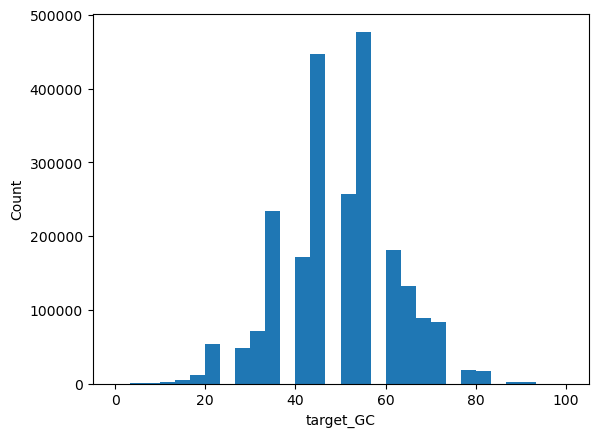

In [24]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trdv4
	ENSMUST00000103679.3: 224 / 415 probes passed the filter 40 < target_GC <  70.
Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trdc
	ENSMUST00000196323.2: 2699 / 3836 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Ighd
	ENSMUST00000194162.6: 1282 / 1777 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192250.2: 600 / 773 probes passed the filter 40 < target_GC <  70.
Iglc2
	ENSMUST00000198182.2: 360 / 429 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103749.3: 484 / 577 probes passed the filter 40 < target_GC <  70.
Gramd3
	ENSMUST00000237355.2: 1730 / 2600 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237422.2: 1604 / 2324 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000070166.6: 1587 / 2576 probes passed the filter 40 < target_

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000226284.2: 5349 / 6237 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000226398.2: 4763 / 5430 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227804.2: 712 / 769 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227745.2: 4897 / 5569 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000228412.2: 4718 / 5403 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227607.2: 3700 / 4240 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227509.2: 332 / 403 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000097373.2: 5157 / 5989 probes passed the filter 40 < target_GC <  70.
Mettl1
	ENSMUST00000152960.2: 250 / 402 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000006915.14: 1388 / 1762 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000120542.8: 798 / 1015 probes passed the filter 40 < target_GC <  70.
Cep55
	ENSMUST00000236044.2: 1164 / 2413 probes passed the filter 40 < target_GC <  70.
	ENSMUST0

	ENSMUST00000032270.13: 634 / 1955 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000169545.8: 373 / 647 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000118447.2: 377 / 655 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032271.13: 489 / 793 probes passed the filter 40 < target_GC <  70.
Klra7
	ENSMUST00000049304.14: 467 / 1046 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000088011.11: 399 / 892 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032286.7: 483 / 1013 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000112013.8: 506 / 1075 probes passed the filter 40 < target_GC <  70.
Krt7
	ENSMUST00000147662.8: 520 / 613 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000068904.9: 3241 / 4065 probes passed the filter 40 < target_GC <  70.
Brca2
	ENSMUST00000202003.4: 1513 / 3444 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000202313.2: 4978 / 10488 probes passed the filter 40 < target_GC <  70.
	ENSMUST

	ENSMUST00000098816.10: 2524 / 3648 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000057784.15: 4567 / 7881 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000141505.2: 255 / 490 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000117077.8: 4416 / 7597 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000118432.2: 2682 / 3652 probes passed the filter 40 < target_GC <  70.
Apoc3
	ENSMUST00000121916.8: 602 / 680 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000034586.9: 423 / 497 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000118649.8: 404 / 424 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000145672.2: 267 / 294 probes passed the filter 40 < target_GC <  70.
Apoa5
	ENSMUST00000121598.8: 2201 / 2486 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000214202.2: 324 / 406 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000215458.2: 286 / 329 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000215

	ENSMUST00000044616.10: 1570 / 3404 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000108319.9: 1533 / 3191 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000108318.3: 1527 / 3140 probes passed the filter 40 < target_GC <  70.
Marveld3
	ENSMUST00000001722.14: 854 / 1301 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000051430.7: 1673 / 2418 probes passed the filter 40 < target_GC <  70.
Sox17
	ENSMUST00000027035.10: 1225 / 3098 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000195555.2: 1037 / 1948 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192650.6: 1774 / 3213 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000116652.8: 761 / 1483 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191647.2: 208 / 377 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191939.2: 466 / 811 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192913.2: 652 / 1477 probes passed the filter 40 < target_GC <  70.
Fn1
	

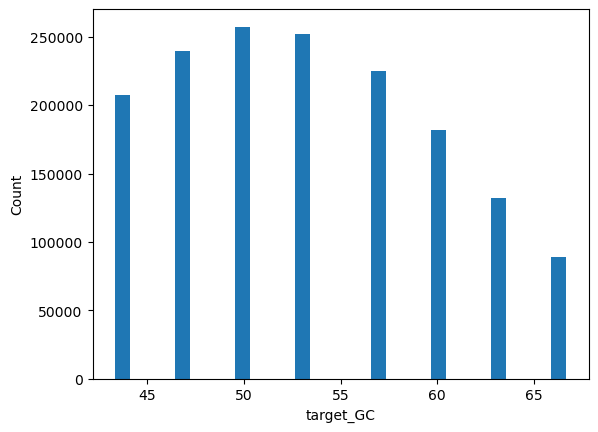

In [25]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

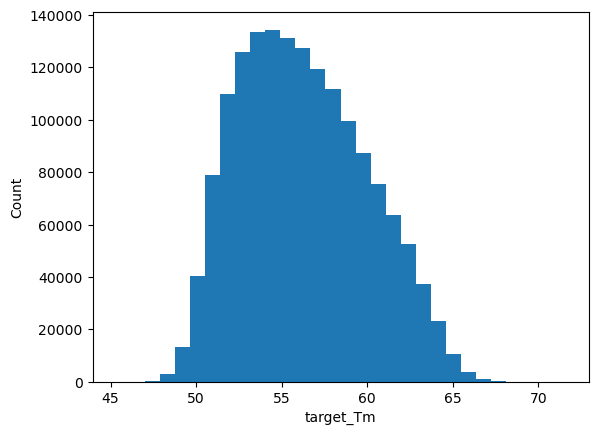

In [26]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trdv4
	ENSMUST00000103679.3: 214 / 224 probes passed the filter 50 < target_Tm <  65.
Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trdc
	ENSMUST00000196323.2: 2548 / 2699 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Ighd
	ENSMUST00000194162.6: 1230 / 1282 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192250.2: 589 / 600 probes passed the filter 50 < target_Tm <  65.
Iglc2
	ENSMUST00000198182.2: 357 / 360 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103749.3: 474 / 484 probes passed the filter 50 < target_Tm <  65.
Gramd3
	ENSMUST00000237355.2: 1692 / 1730 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237422.2: 1568 / 1604 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000070166.6: 1553 / 1587 probes passed the filter 50 < target_

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000115739.9: 3237 / 3326 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234574.2: 1243 / 1288 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115740.9: 3299 / 3397 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115738.8: 3156 / 3245 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234015.2: 995 / 1022 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000045566.7: 3046 / 3136 probes passed the filter 50 < target_Tm <  65.
Top2a
	ENSMUST00000068031.8: 2686 / 2795 probes passed the filter 50 < target_Tm <  65.
Zfyve9
	ENSMUST00000106657.8: 3712 / 3840 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000106658.8: 3535 / 3661 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000042185.8: 1551 / 1592 probes passed the filter 50 < target_Tm <  65.
Cyp2c29
	ENSMUST00000176624.8: 981 / 1016 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000003137.15: 996 / 1039 probes passed the filter 50 < target_Tm <  6

	ENSMUST00000235015.2: 2296 / 2376 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000163123.3: 2273 / 2344 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234923.2: 1375 / 1412 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000086538.10: 2151 / 2222 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000163680.9: 2132 / 2203 probes passed the filter 50 < target_Tm <  65.
Gstp2
	ENSMUST00000042700.12: 687 / 693 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000235381.2: 366 / 366 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000235657.2: 430 / 435 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237999.2: 269 / 269 probes passed the filter 50 < target_Tm <  65.
Rras
	ENSMUST00000044111.10: 748 / 756 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000210895.2: 231 / 237 probes passed the filter 50 < target_Tm <  65.
Pld4
	ENSMUST00000063888.5: 1801 / 1821 probes passed the filter 50 < target_Tm <  65.
Apoe
	ENS

	ENSMUST00000140219.8: 636 / 643 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000143792.8: 779 / 792 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000125770.8: 630 / 632 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145928.8: 784 / 790 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000151212.8: 438 / 441 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000131565.8: 569 / 574 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000128886.8: 552 / 557 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000143226.8: 704 / 717 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000124259.8: 821 / 841 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000139459.8: 662 / 676 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000129020.3: 669 / 684 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000155186.2: 620 / 623 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000129232.8: 648 / 654 probes 

	ENSMUST00000042610.15: 1921 / 2007 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000127730.2: 1868 / 1954 probes passed the filter 50 < target_Tm <  65.
Smc2
	ENSMUST00000102915.10: 2056 / 2116 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000117280.8: 1998 / 2057 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000142227.3: 766 / 787 probes passed the filter 50 < target_Tm <  65.
Wfdc2
	ENSMUST00000017867.10: 657 / 677 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000109344.9: 348 / 352 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000109345.9: 455 / 461 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000125051.2: 314 / 328 probes passed the filter 50 < target_Tm <  65.
Chst3
	ENSMUST00000167915.3: 4594 / 4771 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000068690.7: 4627 / 4807 probes passed the filter 50 < target_Tm <  65.
Tmem100
	ENSMUST00000092788.4: 927 / 942 probes passed the filter 50 < target_Tm <  65.


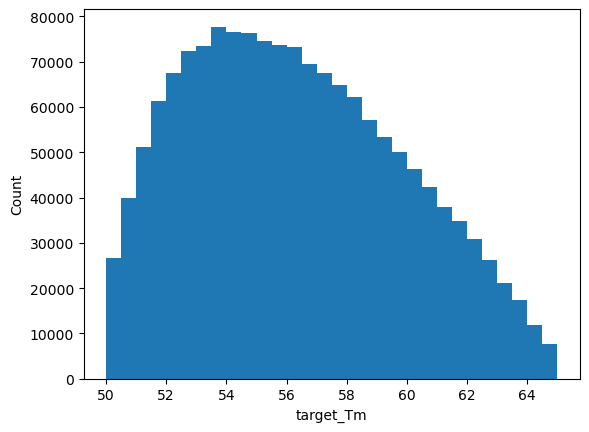

In [27]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [28]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [29]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Mat1a.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Lgr6.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tcf7.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tnfrsf4.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Cxcl14.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Klre1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Cdcp1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Taf1c.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Sh3bgr.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Tnfsf8.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Gstp2.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Gener

Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Rras.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tspan7.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Mrpl55.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Cyp4b1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Mcpt8.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Trac.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Nsg2.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Gja4.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene A230098N10Rik.
Construct a OTTable using 0/0 transcripts with FPKM > 0.
Generate OTTable for gene Smg9.
Cons

Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cyp2a12.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Iglc2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Fam50a.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tdrd3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Prkaa1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Dhx37.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Slc7a2.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Cxcr2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Adgre4.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ccl3.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Dab2.
Constr

Generate OTTable for gene Gm2682.
Construct a OTTable using 0/0 transcripts with FPKM > 0.
Generate OTTable for gene Fermt1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Klk1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Pf4.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene C1qc.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ltf.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene Cdca3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene G0s2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Mrpl51.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tnfsf11.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cd8b1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate O

Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ccn4.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Ftcd.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ptpro.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Dnase2b.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Satb1.
Construct a OTTable using 14/14 transcripts with FPKM > 0.
Generate OTTable for gene Ccr4.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Klrk1.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Cd300e.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ccr2.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Sult1d1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Gm32511.
Const

In [30]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116912/116912 transcripts with FPKM > 0.
Processed 10000/116912 sequences.
Processed 20000/116912 sequences.
Processed 30000/116912 sequences.
Processed 40000/116912 sequences.
Processed 50000/116912 sequences.
Processed 60000/116912 sequences.
Processed 70000/116912 sequences.
Processed 80000/116912 sequences.
Processed 90000/116912 sequences.
Processed 100000/116912 sequences.
Processed 110000/116912 sequences.


In [31]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/380 genes.
Calculate OTs for 1/380 genes.
Calculate OTs for 2/380 genes.
Calculate OTs for 3/380 genes.
Calculate OTs for 4/380 genes.
Calculate OTs for 5/380 genes.
Calculate OTs for 6/380 genes.
Calculate OTs for 7/380 genes.
Calculate OTs for 8/380 genes.
Calculate OTs for 9/380 genes.
Calculate OTs for 10/380 genes.
Calculate OTs for 11/380 genes.
Calculate OTs for 12/380 genes.
Calculate OTs for 13/380 genes.
Calculate OTs for 14/380 genes.
Calculate OTs for 15/380 genes.
Calculate OTs for 16/380 genes.
Calculate OTs for 17/380 genes.
Calculate OTs for 18/380 genes.
Calculate OTs for 19/380 genes.
Calculate OTs for 20/380 genes.
Calculate OTs for 21/380 genes.
Calculate OTs for 22/380 genes.
Calculate OTs for 23/380 genes.
Calculate OTs for 24/380 genes.
Calculate OTs for 25/380 genes.
Calculate OTs for 26/380 genes.
Calculate OTs for 27/380 genes.
Calculate OTs for 28/380 genes.
Calculate OTs for 29/380 genes.
Calculate OTs for 30/380 genes.
Calculate OTs for 

Calculate OTs for 260/380 genes.
Calculate OTs for 261/380 genes.
Calculate OTs for 262/380 genes.
Calculate OTs for 263/380 genes.
Calculate OTs for 264/380 genes.
Calculate OTs for 265/380 genes.
Calculate OTs for 266/380 genes.
Calculate OTs for 267/380 genes.
Calculate OTs for 268/380 genes.
Calculate OTs for 269/380 genes.
Calculate OTs for 270/380 genes.
Calculate OTs for 271/380 genes.
Calculate OTs for 272/380 genes.
Calculate OTs for 273/380 genes.
Calculate OTs for 274/380 genes.
Calculate OTs for 275/380 genes.
Calculate OTs for 276/380 genes.
Calculate OTs for 277/380 genes.
Calculate OTs for 278/380 genes.
Calculate OTs for 279/380 genes.
Calculate OTs for 280/380 genes.
Calculate OTs for 281/380 genes.
Calculate OTs for 282/380 genes.
Calculate OTs for 283/380 genes.
Calculate OTs for 284/380 genes.
Calculate OTs for 285/380 genes.
Calculate OTs for 286/380 genes.
Calculate OTs for 287/380 genes.
Calculate OTs for 288/380 genes.
Calculate OTs for 289/380 genes.
Calculate 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000106657.8: 3712 / 3712 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000106658.8: 3535 / 3535 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000042185.8: 1551 / 1551 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cyp2c29
	ENSMUST00000176624.8: 981 / 981 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000003137.15: 996 / 996 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cyp2c39
	ENSMUST00000025968.5: 901 / 901 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tnfsf8
	ENSMUST00000030047.3: 1936 / 1936 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Prdm1
	ENSMUST00000039174.11: 3035 / 3054 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000105490.3: 2361 / 2380 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000218369.2: 1903 / 1903 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Hpd
	ENSMUST00000031398.14: 1278 / 1278 probes passed the filter 

	ENSMUST00000174064.9: 1023 / 1023 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000173739.8: 926 / 926 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174355.8: 839 / 839 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000003066.16: 861 / 861 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000172983.8: 581 / 581 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174144.8: 558 / 558 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000172808.2: 359 / 359 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174710.2: 443 / 443 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174191.2: 401 / 401 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Sugct
	ENSMUST00000068545.6: 950 / 950 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000221598.2: 33 / 33 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST000002

	ENSMUST00000197575.2: 379 / 379 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ldb2
	ENSMUST00000199534.5: 1493 / 1493 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000070748.10: 1371 / 1371 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000199256.5: 1529 / 1529 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000199261.2: 1328 / 1328 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Kifc1
	ENSMUST00000173492.9: 2007 / 2007 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000173982.2: 264 / 264 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000173386.2: 606 / 606 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000114361.9: 1923 / 1923 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Vpreb3
	ENSMUST00000121151.2: 586 / 586 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000000926.3: 485 / 485 probes passed the filter -inf < target_OT_rtRN

	ENSMUST00000119798.3: 826 / 826 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000172559.2: 817 / 817 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Mrpl41
	ENSMUST00000045604.4: 578 / 578 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000194392.2: 285 / 285 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Csrp3
	ENSMUST00000167786.4: 751 / 751 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000032658.14: 731 / 731 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208050.2: 323 / 323 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ccl24
	ENSMUST00000004936.10: 1004 / 1004 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000201401.2: 470 / 470 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Fxyd3
	ENSMUST00000167369.8: 2441 / 2441 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000072331.13: 324 / 324 probes passed the filter -inf < target_OT_rtR

### Off-targets to transcriptome

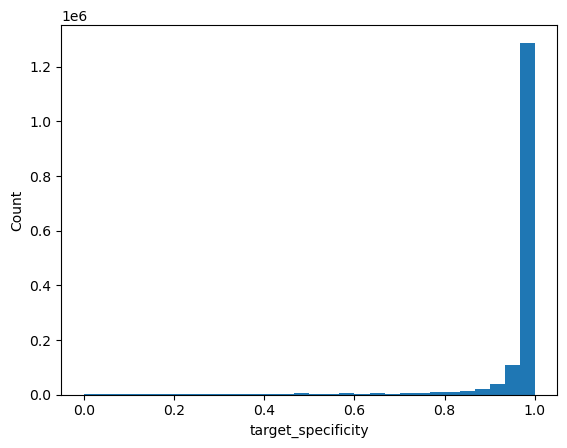

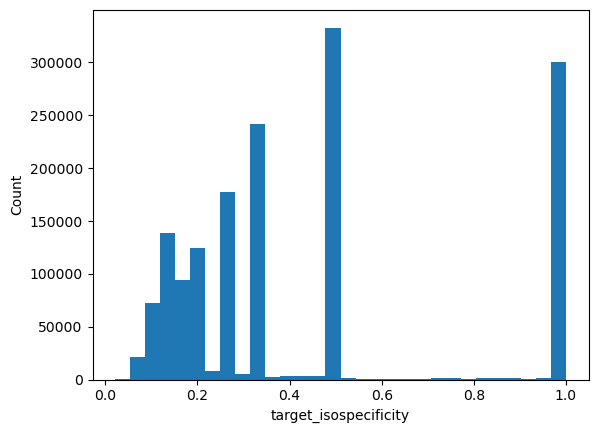

In [32]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [33]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

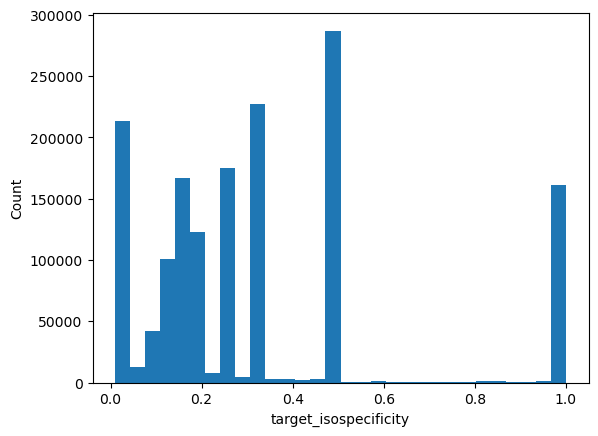

In [34]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trdv4
	ENSMUST00000103679.3: 158 / 214 probes passed the filter 0.99 < target_specificity <  inf.
Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trdc
	ENSMUST00000196323.2: 2097 / 2486 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 536 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 263 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Ighd
	ENSMUST00000194162.6: 946 / 1230 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000192250.2: 495 / 589 probes passed the filter 0.99 < target_specificity <  inf.
Iglc2
	ENSMUST00000198182.2: 104 / 357 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103749.3: 167 / 474 probes passed the filter 0.99 < target_specificity <  inf.
Gramd3
	ENSMUST00000237355.2: 1354 / 1692 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000237422.2: 1245 / 1568 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000045566.7: 2531 / 3033 probes passed the filter 0.99 < target_specificity <  inf.
Top2a
	ENSMUST00000068031.8: 1829 / 2670 probes passed the filter 0.99 < target_specificity <  inf.
Zfyve9
	ENSMUST00000106657.8: 2857 / 3712 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000106658.8: 2694 / 3535 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000042185.8: 1171 / 1551 probes passed the filter 0.99 < target_specificity <  inf.
Cyp2c29
	ENSMUST00000176624.8: 202 / 981 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000003137.15: 279 / 996 probes passed the filter 0.99 < target_specificity <  inf.
Cyp2c39
	ENSMUST00000025968.5: 205 / 901 probes passed the filter 0.99 < target_specificity <  inf.
Tnfsf8
	ENSMUST00000030047.3: 1423 / 1936 probes passed the filter 0.99 < target_specificity <  inf.
Prdm1
	ENSMUST00000039174.11: 2405 / 3035 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000105490.3:

	ENSMUST00000174064.9: 869 / 1023 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173739.8: 772 / 926 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174355.8: 707 / 839 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000003066.16: 732 / 861 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000172983.8: 484 / 581 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174144.8: 499 / 558 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000172808.2: 316 / 359 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174710.2: 324 / 443 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174191.2: 282 / 401 probes passed the filter 0.99 < target_specificity <  inf.
Sugct
	ENSMUST00000068545.6: 814 / 950 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000221598.2: 29 / 33 probes passed the filter 0.99 < target_sp

	ENSMUST00000070748.10: 1087 / 1371 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000199256.5: 1216 / 1529 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000199261.2: 1096 / 1328 probes passed the filter 0.99 < target_specificity <  inf.
Kifc1
	ENSMUST00000173492.9: 95 / 2007 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173982.2: 11 / 264 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173386.2: 37 / 606 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000114361.9: 95 / 1923 probes passed the filter 0.99 < target_specificity <  inf.
Vpreb3
	ENSMUST00000121151.2: 502 / 586 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000000926.3: 428 / 485 probes passed the filter 0.99 < target_specificity <  inf.
Fam178b
	ENSMUST00000170295.8: 1531 / 1972 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000114981.3: 1023 / 1369 probes passed the

	ENSMUST00000129306.4: 530 / 648 probes passed the filter 0.99 < target_specificity <  inf.
Ddx55
	ENSMUST00000071057.14: 1463 / 2035 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000111438.2: 1414 / 1985 probes passed the filter 0.99 < target_specificity <  inf.
Tnfrsf4
	ENSMUST00000030952.6: 702 / 922 probes passed the filter 0.99 < target_specificity <  inf.
Lcn2
	ENSMUST00000050785.14: 560 / 756 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000192241.2: 527 / 720 probes passed the filter 0.99 < target_specificity <  inf.
Scart1
	ENSMUST00000209398.2: 2313 / 2978 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000209637.2: 2123 / 2769 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000084460.7: 2306 / 2985 probes passed the filter 0.99 < target_specificity <  inf.
Chil1
	ENSMUST00000156873.8: 1154 / 1419 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000082060.10: 1192 / 145

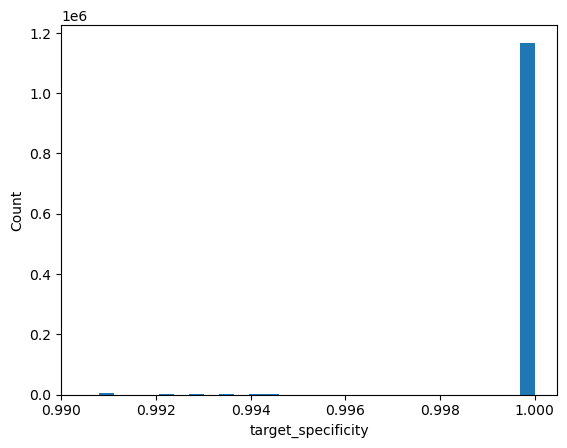

In [35]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## save probe_dict

In [36]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/2023_10_19_full_probe_isoforms.pkl


## Restart here

In [37]:
import pickle
full_probe_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/2023_10_18_full_probe_isoforms.pkl'
if 'probe_dict' not in locals():
    probe_dict = pickle.load(open(full_probe_filename, 'rb'))
replace_dict = np.load(os.path.join(library_folder, 'replace_dict.npy'), allow_pickle=True).item()

## Select probe isoform

In [38]:
## Select transcript based on length / number of possible probes:
largest_probe_th = 800
median_probe_th = 400


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trac
Iglc2
Cenpw
Clec4a3
Klk1
Basp1
Cyp3a25
Cyp2c29
Sh3bgr
Ly6g
Akr1c6
Serpina3m
Ms4a4c
Ms4a2
Mcrs1
Prok2
Klrc2
Klrc1
Klra7
Klra3
Gstp2
Rras
Cd3g
Gm21762
Rpl7l1
Apoc3
Kifc1
S100a4
Pf4
Apoa2
Fcer1a
Wfdc2
Mrgpra2b
Mrpl41
Fbl
Ifitm1
Ifitm6


In [39]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[158] [158]
ENSMUST00000103679.3 158
[154] [154]
ENSMUST00000103299.3 154
[2097] [2097]
ENSMUST00000196323.2 2097
[536, 263] [263, 263]
ENSMUST00000198398.5 536
[946, 495] [431, 431]
ENSMUST00000194162.6 946
[104, 167] [104, 104]
ENSMUST00000103749.3 167
[1354, 1245, 1258] [1314, 1244, 1195]
ENSMUST00000237355.2 1354
[2032, 1863] [1863, 1863]
ENSMUST00000122333.2 2032
[2293] [2293]
ENSMUST00000057243.6 2293
[1696, 1712] [1696, 1696]
ENSMUST00000228218.2 1696
[745, 819, 290] [701, 703, 285]
ENSMUST00000109535.3 819
[1367, 111] [372, 86]
ENSMUST00000090473.7 1367
[2944, 3031] [2924, 2924]
ENSMUST00000166783.3 2944
[3733, 3891, 1299, 223, 2732, 1143, 517] [3733, 3891, 1227, 219, 2732, 1133, 511]
ENSMUST00000239048.2 3891
[2911, 1563] [1515, 1515]
ENSMUST00000093852.5 2911
[2747, 2795, 172] [2747, 2610, 44]
ENSMUST00000136381.8 2747
[1334] [1334]
ENSMUST00000022722.7 1334
[1609, 171, 472, 2101, 1310, 1270, 677, 219, 398, 1127, 1989] [1609, 156, 457, 2028, 1310, 1265, 532, 172, 227, 1127, 1

ENSMUST00000006760.3 1280
[1968, 529, 1935, 341, 196] [1968, 503, 1924, 341, 144]
ENSMUST00000108222.9 1968
[3863, 1279] [1244, 1198]
ENSMUST00000034766.14 3863
[1358, 1514, 593] [1256, 1256, 437]
ENSMUST00000111763.8 1358
[733] [733]
ENSMUST00000052712.6 733
[1355, 1309, 1244, 1244] [1219, 1220, 1244, 1244]
ENSMUST00000119369.2 1244
[1404] [1404]
ENSMUST00000027507.9 1404
[705, 285, 681, 664, 455, 658, 645, 641, 643, 665, 686, 663] [696, 249, 681, 664, 363, 658, 645, 641, 643, 643, 686, 653]
ENSMUST00000188028.7 705
[362, 887, 278, 312] [332, 332, 269, 272]
ENSMUST00000199183.5 887
[3314] [3314]
ENSMUST00000089776.3 3314
[906, 376, 224] [358, 376, 127]
ENSMUST00000148665.8 906
[3162, 1260, 1215, 867, 814, 733, 216] [1246, 1236, 1117, 849, 798, 715, 192]
ENSMUST00000027146.9 3162
[971, 551] [455, 455]
ENSMUST00000005606.8 971
[293, 268, 251, 269] [249, 248, 231, 231]
ENSMUST00000111321.8 293
[1183, 189, 442, 980] [984, 189, 438, 980]
ENSMUST00000114487.9 1183
[329] [329]
ENSMUST0000006

In [40]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdv4
	ENSMUST00000103679.3	158
Trbc2
	ENSMUST00000103299.3	154
Trdc
	ENSMUST00000196323.2	2097
Trac
	ENSMUST00000198398.5	536
Ighd
	ENSMUST00000194162.6	946
Iglc2
	ENSMUST00000103749.3	167
Gramd3
	ENSMUST00000237355.2	1354
Klhl14
	ENSMUST00000122333.2	2032
Tmem252
	ENSMUST00000057243.6	2293
Prkaa1
	ENSMUST00000228218.2	1696
Tnfrsf13c
	ENSMUST00000109535.3	819
Gpr88
	ENSMUST00000090473.7	1367
Ablim3
	ENSMUST00000166783.3	2944
Septin3
	ENSMUST00000239048.2	3891
Zbtb16
	ENSMUST00000093852.5	2911
Sidt1
	ENSMUST00000136381.8	2747
Acod1
	ENSMUST00000022722.7	1334
Dab2
	ENSMUST00000080880.12	2101
Epcam
	ENSMUST00000053577.9	846
Atp8a2
	ENSMUST00000080368.13	7203
Camk4
	ENSMUST00000042868.6	1136
Themis
	ENSMUST00000056097.11	1510
Btbd11
	ENSMUST00000105307.8	3226
Rrs1
	ENSMUST00000072079.9	352
Nup85
	ENSMUST00000021085.11	1373
Cd200r3
	ENSMUST00000114611.10	653
Ddx28
	ENSMUST00000058579.7	1437
Cenpw
	ENSMUST00000216853.2	490
Gata2
	ENSMUST00000015197.9	1603
Ifng
	ENSM

In [41]:
sequencing_data_folder = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X'
manual_kept_genes = pd.read_csv(os.path.join(sequencing_data_folder, 'merfish_4T1_genes_removed.csv'))

In [42]:
kept_gene_list = []
removed_gene_list = []
for _gene, _t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if len(_pbs) < 600 and _gene not in list(manual_kept_genes['gene']):
        print(_gene)
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

Trdv4
Trbc2
Trac
Iglc2
Rrs1
Cenpw
Clec4a1
Clec4a3
Fabp1
Clec4d
Cyp2a12
Klk1b27
Klk1
Basp1
Cyp3a25
Cyp2c29
Cyp2c39
Krt14
Krt17
Akr1c6
Pglyrp1
Serpina3m
Ms4a4c
Ms4a6c
Ms4a3
Mcrs1
Dusp10
Klre1
Prok2
Ces1b
Klrc2
Klrc1
Klra7
Klra3
Krt8
Krt18
Gstp2
Rras
Stfa2l1
Cstdc6
Cstdc5
Stfa2
Camp
Cox6a2
H1f5
Polr2g
Hilpda
Gm21762
Cd40lg
Sult1d1
Apoc3
Icos
Cma1
Mcpt8
Ccl8
G0s2
Xcl1
Kifc1
Vpreb3
S100a4
Wfdc17
Wfdc21
Pf4
Apoa2
Gemin6
Ggh
Mrgpra2b
Mrpl41
Lcn2
Ccl5
Mrpl55
Cstf1
Gtf3a
Fbl
Ifitm1
Ifitm6
Ccl7
Ccl12
Dapl1


In [43]:
len(kept_gene_list)

301

In [44]:
target_gene_mean_exp_df.loc[np.array(kept_gene_list)]


,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,Neutrophil_mN1_liver,Tcell_CD4_memory,NKT_cells,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Trdc,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,0.000432,0.022925,0.144608,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,0.002842,0.002391,0.003484,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Gramd3,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,0.007093,2.386506,1.935409,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Klhl14,0.001232,0.001544,0.349993,0.002983,0.001354,0.001788,0.000830,0.001048,0.001018,0.000000,...,0.000000,0.000000,0.004909,0.004353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tmem252,0.000183,0.000112,0.000000,0.000000,0.000000,0.000576,0.000581,0.000000,0.001012,0.000000,...,0.000000,0.359993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Azgp1,0.000842,0.000000,0.000423,0.000000,0.000705,0.000000,0.000000,0.000000,0.000000,0.003256,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.959204,0.013355,0.000000,0.000000,0.000000
Pms2,0.009502,0.006433,0.085660,0.021158,0.055663,0.033777,0.006720,0.009777,0.104119,0.098586,...,0.066626,0.060471,0.116089,0.033027,0.035858,0.000000,0.093359,0.002934,0.069166,0.090643
Fzd2,0.000000,0.000000,0.000000,0.002899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000535,...,0.143754,0.000000,0.000000,0.003481,0.244014,0.000000,0.000000,0.020520,0.000000,0.000000


In [45]:
replace_dict

{'Tcrg-C1': 'Trgc1',
 'Tcrg-C2': 'Trgc2',
 'Tcrg-C4': 'Trgc4',
 'Sept1': 'Septin1',
 'H2afy': 'Macroh2a2',
 'Qk': 'Qki',
 'Hist1h1b': 'H1f5',
 'Fam129b': 'Niban2',
 'Sept3': 'Septin3',
 'Hist1h2ab': 'H2ac4',
 'Il1f9': 'Il36g',
 'Cd163l1': 'Scart1',
 'Hist1h2af': 'H2ac10',
 'Fam71f2': 'Garin1a',
 'Hist1h3c': 'H3c3',
 'Ero1l': 'Ero1a',
 'Fam129c': 'Niban3',
 'Gm14548': 'Pira12',
 'Ptprg': 'PTPRG'}

In [46]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [47]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

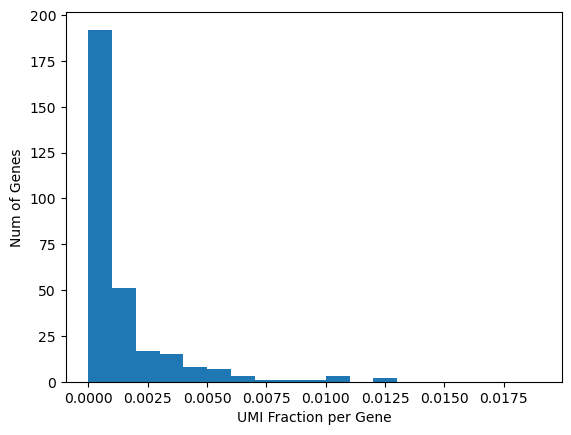

In [48]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

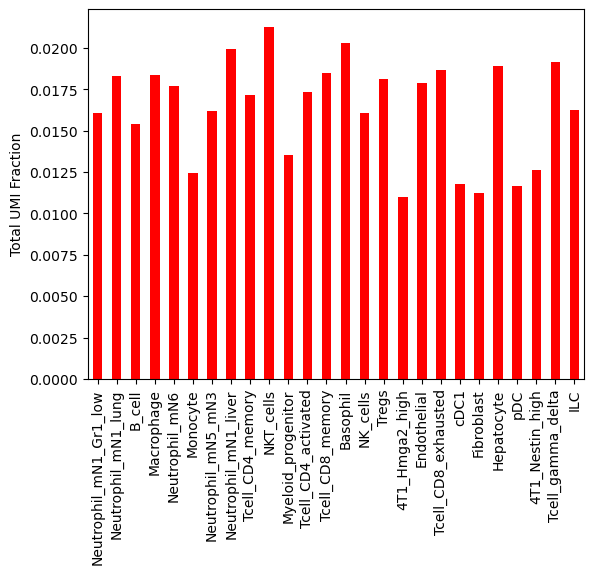

In [49]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [50]:
len(kept_gene_list)

301

## determine marker gene group

In [51]:
group_2_genes = {_g:[] for _g in target_gene_mean_exp_df.columns}
for _gene in kept_gene_list:
    _exp = target_gene_mean_exp_df.loc[_gene]
    _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

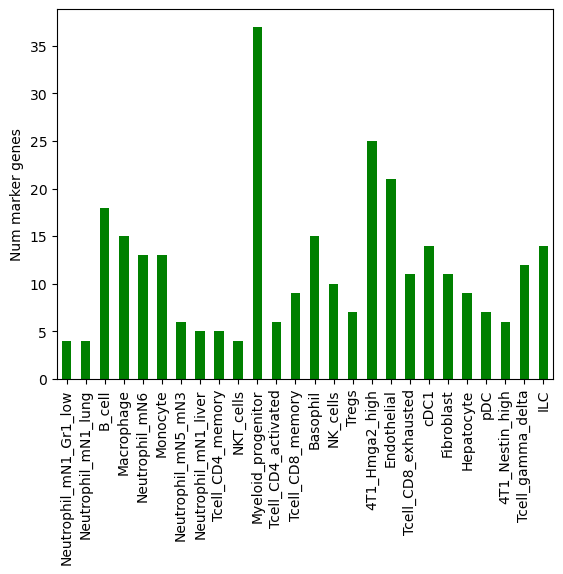

In [52]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

In [53]:
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

In [54]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(sel_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/2023_10_19_candidate_probe.pkl


In [55]:
# load probe_dict
probe_dict = pickle.load(open(full_probe_filename, 'rb'))

In [56]:
# delete
del(probe_dict)

In [57]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)
print(kept_gene_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/kept_gene_info.csv


In [58]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Trdc,ENSMUST00000196323.2,2097,Tcell_gamma_delta,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,ENSMUST00000194162.6,946,B_cell,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Gramd3,ENSMUST00000237355.2,1354,Tcell_CD8_memory,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Klhl14,ENSMUST00000122333.2,2032,B_cell,0.001232,0.001544,0.349993,0.002983,0.001354,0.001788,0.000830,...,0.000000,0.000000,0.004909,0.004353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tmem252,ENSMUST00000057243.6,2293,Endothelial,0.000183,0.000112,0.000000,0.000000,0.000000,0.000576,0.000581,...,0.000000,0.359993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Azgp1,ENSMUST00000035390.7,825,Hepatocyte,0.000842,0.000000,0.000423,0.000000,0.000705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.959204,0.013355,0.000000,0.000000,0.000000
Pms2,ENSMUST00000148011.8,2980,NK_cells,0.009502,0.006433,0.085660,0.021158,0.055663,0.033777,0.006720,...,0.066626,0.060471,0.116089,0.033027,0.035858,0.000000,0.093359,0.002934,0.069166,0.090643
Fzd2,ENSMUST00000057893.7,1376,Fibroblast,0.000000,0.000000,0.000000,0.002899,0.000000,0.000000,0.000000,...,0.143754,0.000000,0.000000,0.003481,0.244014,0.000000,0.000000,0.020520,0.000000,0.000000
Slc24a3,ENSMUST00000110007.8,2169,Basophil,0.011415,0.014678,0.006994,0.067269,0.012917,0.005912,0.068130,...,0.029901,0.067298,0.035639,0.015724,0.110635,0.026548,0.006083,0.008232,0.103887,0.015409


In [59]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
print(removed_gene_filename)
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/removed_genes.csv


# PAUSE HERE, go to jupyter-3 to design codebook